# Synthetic Data Generation and Data Augmentation

## Introduction

In this exercise, we will explore an exciting approach to tackling vision problems when labeled ground truth data is either unavailable or limited in quantity. We aim to conduct experiments with the benefits of full supervision, even under such challenging circumstances.

Our specific focus will be on solving the problem of semantic segmentation, where we aim to accurately segment a target object in an image.

In our experiment, the target object is available as a 3D model and no labelled real-world training data is available.

To still achieve our goal, we will follow a structured approach.

1. **Synthetic Data Generation**: We will leverage the power of **BlenderProc**, a versatile tool, to create synthetic training data. This allows to generate labeled data without manual efford.

2. **Data Augmentation**: To further increase the varity of the data during training, we will explore different data augmentation techniques. By augmenting our dataset, we can introduce variations and increase the robustness of the trained model.

3. **Building the Segmentation Network**: We will construct a state-of-the-art segmentation network called **U-NET**. This network architecture employs a pretrained **MobileNetV2** backbone, which provides a strong foundation for accurate segmentation. We will train the network with our generated data and we will also use the implemented data augmentation.


**IMPORTANT NOTE ON HAND-IN PROCESS**

Besides the saved notebook, please also hand in the maniuplated files `dataset_generator.py` and `quickstart.py`, as well as a ***sample from your generated dataset*** (one image and mask) and the `loss_plot.png` image (several versions, if you did several tests) and a ***brief interpretation of the results***. Everything can be handed in as one zip file.

**Besides this notebook the edited files are not saved in Colab persistently, so  remember to copy the intermediate results to your computer.**


# Prerequirities

We will first import the necessary data. Please, before running the following code, access the link below, right click on the .zip file, then click "Add shortcut to Drive" and select your Drive folder:

https://drive.google.com/drive/folders/1KoQG7jkQXk5_oi16gRfLWgvgFQQYcf2A?usp=sharing

In [48]:
#from google.colab import drive

#drive.mount('/content/drive')

#!unzip -qq './Resources_DNN4VC_Synthetic.zip'

**Make shure to request GPUs from Colab!**

-> Small arrow in the top-right corner -> "View Resources" -> "Change runtime type" (in the bottom)

**Make a copy to allow saving!**


## Part 1: Data generation

Next we are going to take a look at the object we want to recognize. Luckily, we have got a 3D scan of it.
We can use the `trimesh` to take a look at the object.

In [49]:
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import trimesh
import numpy as np

# Load the PLY file
mesh = trimesh.load_mesh('/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic/resources/lm/models/obj_000002.ply')
s = trimesh.Scene()
s.add_geometry(mesh)
s.show()


Next, we will have a look at our test data. Use the following script to show example images. In the path, you can replace `test_data` with `train_data/example` to see a preview image similar to the dataset you will create later.


**Important**: In our example we have ground truth mask for the test images to evaluate the models performance.

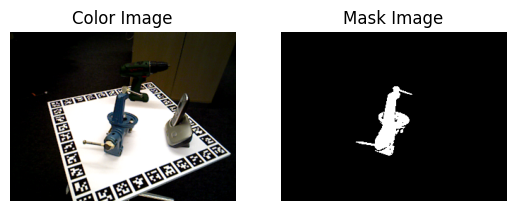

In [ ]:
import matplotlib.pyplot as plt
import cv2

img_no = 1
# Load the color image and the mask image
color_image = cv2.imread('./Resources_DNN4VC_Synthetic/test_data/img/{:04}.png'.format(img_no))
mask_image = cv2.imread('./Resources_DNN4VC_Synthetic/test_data/masks/{:04}.png'.format(img_no))

# Convert the images from BGR to RGB
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

axs[0].imshow(color_image)
axs[0].axis('off')
axs[0].set_title('Color Image')
axs[1].imshow(mask_image)
axs[1].axis('off')
axs[1].set_title('Mask Image')

# Show the figure
plt.show()

## 1.1 Preparation of BlenderProc

Next, we are going to use [BlenderProc](https://github.com/DLR-RM/BlenderProc]). We install it by cloning the official git repository and then install it via pip.

In [ ]:
!git clone https://github.com/DLR-RM/BlenderProc.git
%cd "BlenderProc"
%pip install -e .

Klone nach 'BlenderProc'...


remote: Enumerating objects: 43049, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 43049 (delta 162), reused 221 (delta 149), pack-reused 42795
Empfange Objekte: 100% (43049/43049), 90.45 MiB | 18.55 MiB/s, fertig.
Löse Unterschiede auf: 100% (32458/32458), fertig.
Aktualisiere Dateien: 100% (645/645), fertig.
/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/BlenderProc
Obtaining file:///vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/BlenderProc
  Preparing metadata (setup.py) ... done
  Using cached PyYAML-6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (682 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=d52b2cb98d50e815016cb8db5330e8704a21d9d05434

To be able to use matplotlib inside BlenderProc, we have to install ipykernel inside blender's python environment. As this is the first blenderproc command, it will also install blender first:

In [ ]:
!blenderproc pip install ipykernel --blender-install-path ./

Lastly, we execute the BlenderProc program by invoking blenderproc run along with the necessary command line arguments. The initial argument indicates the path to the Python file that should be executed. The second argument corresponds to the camera pose file. In this instance, we have specified two camera poses in the `examples/basics/basic/camera_positions` file. The third argument pertains to the output directory where the generated data will be saved.

To ensure compatibility, we use the `--blender-install-path` flag to specify a custom Blender installation path, as the availability of a user folder in Colab is limited.

In [ ]:
!blenderproc run examples/basics/basic/main.py examples/resources/camera_positions examples/resources/scene.obj examples/basics/basic/output --blender-install-path ./

Using blender in ./blender-3.3.1-linux-x64
Using temporary directory: /dev/shm/blender_proc_3bdbd1f667804876ba8005b91382dd2f
Blender 3.3.1 (hash b292cfe5a936 built 2022-10-05 00:14:35)
Installing pip package wheel None
Installing pip package wheel None
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Installing pip package pyyaml 5.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.0/265.0 kB 4.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp310-cp310-linux_x86_64.whl size=44119 sha256=8c56e930a1dcb52c40547af811423788e0c8d379628341c8d7aa38b77ba10f75
  Stored in directory: /vol/fob-vol4/mi17/christod/.cache/pip/wheels/1c/77/3e/dcf9cc5e235189dedcf5f1736a14caaac20267a5bb846c8ce1
Successfully built pyyaml
Installing pip package imageio 2.9.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━

We generated two example images, which we now will take a look at. As you will see, Blender Proc did not only generate the colors, but also the normals and depth information.


examples/basics/basic/output/0.hdf5: 
Keys: 'colors': (512, 512, 3), 'depth': (512, 512), 'normals': (512, 512, 3)


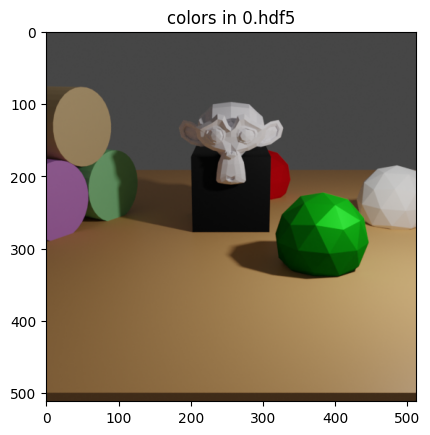

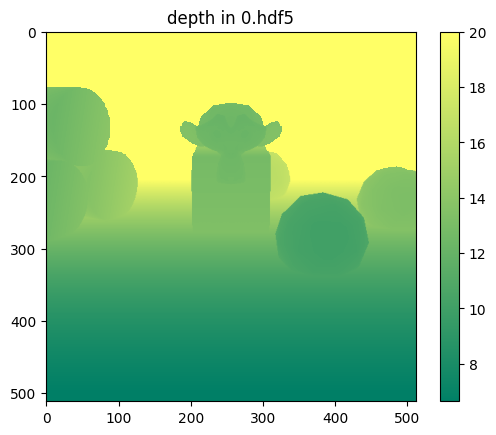

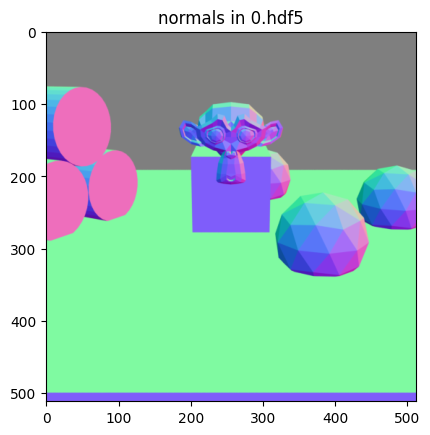

In [ ]:
%run "-m" "blenderproc" "vis" "hdf5" "examples/basics/basic/output/0.hdf5"

examples/basics/basic/output/1.hdf5: 
Keys: 'colors': (512, 512, 3), 'depth': (512, 512), 'normals': (512, 512, 3)


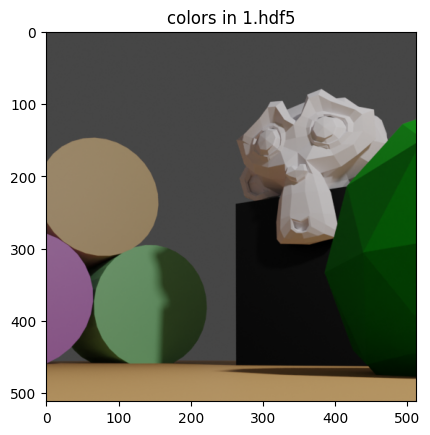

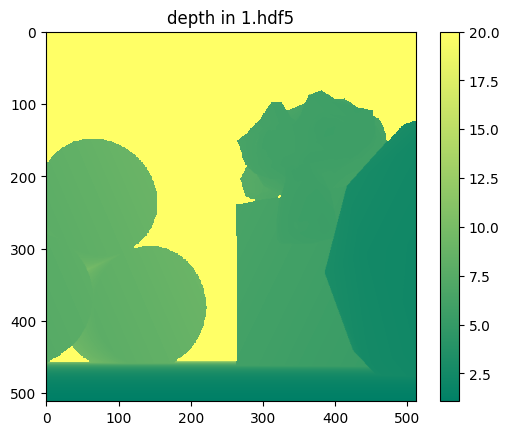

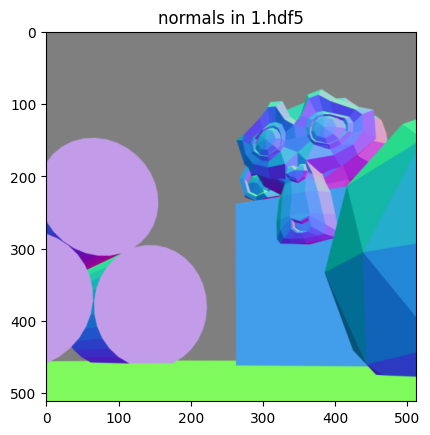

In [ ]:
%run "-m" "blenderproc" "vis" "hdf5" "examples/basics/basic/output/1.hdf5"

As you saw before, executing BlenderProc differs from running a regular Python file. Instead of directly executing the Python script, BlenderProc runs within the context of Blender's integrated Python environment. This integration allows Blender to execute the specified Python script and perform the desired tasks using its internal functionality and capabilities.

```
!blenderproc run examples/basics/basic/main.py
```



## 1.1. Getting started with BlenderProc

Colab allows us to open a script in an integrated editor. To do so, open the "Files" panel on the left (File icon), navigate to `Resources_DNN4VC_Synthetic/scripts/` and double click `quickstart.py`. The file will open on the right side of the screen. Get familiar with the script and test it using the code block below.


**Task 1a)**: Do the following things:

1. Use `bproc.loader.load_obj` to load `obj_000002.ply` (path was given above, when viewing the Mesh).
2. Set a custom camera matrix with `bproc.camera.set_intrinsics_from_K_matrix` [docs](https://dlr-rm.github.io/BlenderProc/blenderproc.api.camera.html). Use the camera matrix given below. Render images with the size 320 by 240. Caution, the camera calibration is given for a resolution of 640 by 480. It has to be scaled accordingly.
3. Adapt the light position and transform mat according to the scale of our example object. For the example object the unit is cm while for the Monkey it is m.

\begin{equation*}
\mathbf{C} = \begin{bmatrix}
537.5 & 0 & 318.9 \\
0 & 536.1 & 238.4 \\
0 & 0 & 1
\end{bmatrix}
\end{equation*}




While adapting the code, you can check the generated image using the following code lines. The output is shown by executing the code box below. You can play around with the code to get familiar with BlenderProc.

**IMPORTANT** When you are ready with code, make sure to save a copy, as the files will not be necessarily be saved when restarting the notebook.

Using blender in ./blender-3.3.1-linux-x64
Using temporary directory: /dev/shm/blender_proc_f983effe2b3f4d5da3c26d0aba4b6b2b
Blender 3.3.1 (hash b292cfe5a936 built 2022-10-05 00:14:35)
Selecting render devices...
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device Intel Xeon Gold 6354 CPU @ 3.00GHz of type CPU found and used.

Successfully imported '/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic/resources/lm/models/obj_000002.ply' in 1.655 sec
Rendering 1 frames of colors...
Total         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ -:--:--  
Total         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ -:--:--  
Total         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ -:--:--  
Total         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ -:--:--  
Total         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

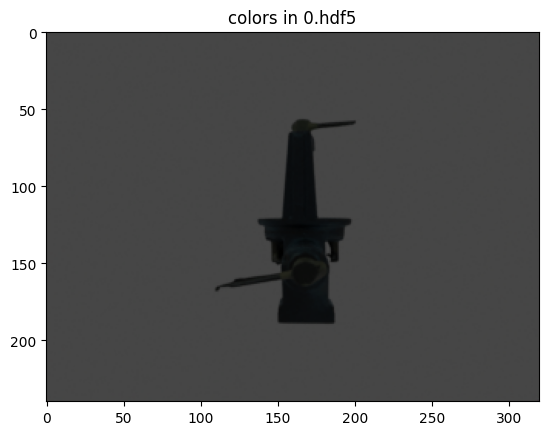

In [77]:
!blenderproc run /vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic/scripts/quickstart.py --blender-install-path ./
%run "-m" "blenderproc" "vis" "hdf5" "output/0.hdf5"

## 1.2 Generating the training dataset

Now, we will generate the actual dataset. Similar to our test data, the object should be placed in upright position in a room (without ceiling) shaped test environment with random material.

**Task 1b)**:
The script to do so is already given, but a couple of tasks have to be performed.

1. Use correct camera matrix (see Task 1a).
2. Load and place distractor objects
3. Complete the 'room' environment
4. Sample random camera poses
5. Activate segmentation output
6. Save dataset in the same format as the testing data.

A detailed despriction is given directly in the script and should be added there.

The code box below allows to test the script. The initial version can be executed, but will only save an example output.


In [147]:
%env BASE_PATH=/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic
!blenderproc run $BASE_PATH/scripts/dataset_generator.py \
    --mesh_path $BASE_PATH/resources/lm \
    --cc_textures_path $BASE_PATH/resources/cctextures \
    --output_dir $BASE_PATH/train_data \
    --num_samples 1 \
    --start_index 1 \
    --blender-install-path ./

env: BASE_PATH=/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic
Using blender in ./blender-3.3.1-linux-x64
Using temporary directory: /dev/shm/blender_proc_3af544eb85594e668065a5efb3178b3b
Blender 3.3.1 (hash b292cfe5a936 built 2022-10-05 00:14:35)
Selecting render devices...
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device NVIDIA RTX A6000 of type OPTIX found and used.
Device Intel Xeon Gold 6354 CPU @ 3.00GHz of type CPU found and used.
bob: /vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic/resources/lm, dataset_path: /vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic/resources
dataset: lm

Successfully imported '/vol/fob-vol4/mi17/christod/Visual_Computing/exercises/exercise_05/Resources_DNN4VC_Synthetic/resources/lm/models/obj_000002.

**IMPORTANT** When you are ready with code, make sure to save a copy, as the files will not be necessarily be saved when restarting the notebook.

**Final dataset creation:**
7. Each execution of the scripts creates n samples. Use start_index and num samples and generate at least 256 images (16 calls with each 16 images). Make sure that the output is correct before generating the output. You could create a loop in python to automate everything
`os.system(f"blenderproc run ...")`. Generating the dataset might take 10 minutes.

In [ ]:
'''
Generate the whole dataset (256 images) by calling the script 16 times for 16 samples each.
Perhaps you find an elegant solution.
'''

**IMPORTANT**: Download you generated dataset as a backup.First create a tar file and the download the file via the "Files" plane. Also download your edited scripts (if not done already).

In [ ]:
!tar -czf /content/Resources_DNN4VC_Synthetic/train_data.tar.gz /content/Resources_DNN4VC_Synthetic/train_data


## Part 2: Data augmentation

Now, we are going to build a data loader, which performs data augmentation to create more variation in our training data.

In [ ]:
%cd /content/Resources_DNN4VC_Synthetic/

First all packages, we will need later will be importet. This example will mainly use torch and torchvision.

In [ ]:
import torch
import os
import random

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as TF

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models.mobilenetv2 import InvertedResidual

from utils.utils import plot_batch, plot_output
from utils.imgaug_pipeline import heavy_augmentation



## 2.1 Preparing dataset and dataloader

First a custom dataset is created.

In the constructor a list of all files in the "img" dir is prepared.
The `__getitem__` function will load a sample and transform the mask and the image with a **torchvision** transformation.

It will then return a single sample constiting of an image and a mask.




In [ ]:
class CustomDataset(Dataset):
    def __init__(
        self, root_dir, transform, transform_mask, geometric_augmentation=False, imgaug_heavy_augmentation=False
    ):
        self.root_dir = root_dir
        self.transform = transform
        self.transform_mask = transform_mask

        self.img_dir = os.path.join(root_dir, "img")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_filenames = sorted(os.listdir(self.img_dir))
        self.geometric_augmentation = geometric_augmentation  # This will be used later
        self.imgaug_heavy_augmentation = imgaug_heavy_augmentation # This will be used later

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        mask_path = os.path.join(self.mask_dir, img_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # This will be used later
        if self.geometric_augmentation:
            image, mask = self.common_transform(image, mask)

        # This will be used later
        if self.imgaug_heavy_augmentation:
            image = self.apply_imgaug_pipeline(image)

        image = self.transform(image)
        mask = self.transform_mask(mask)


        return image, mask

    def common_transform(self, image, mask, rotation_angle=15, crop_offset=16, img_size=224):

        '''
        Add augmentation here and use the same parameters for image and mask
        IMPORTANT: Use BILINEAR inperpolation when rotating, scaling the image and nearest neighbor interpolation when doing the same with the mask.
        '''
        # Random rotation (hint: random.uniform, TF.rotate)
        # ...

        # Random crop  (hint: transforms.RandomCrop.get_params, TF.crop)
        # ...

        # Resize to 224x224
        # image = ...
        # mask = ...

        # Random horizontal flipping
        #if random.random() > 0.5:
        #    image = ...
        #    mask = ...

        # Random horizontal flipping
        # ...
        return image, mask

    def apply_imgaug_pipeline(self, image):
      image = np.array(image)
      image = heavy_augmentation(image=image)

      return Image.fromarray(image)



The transformation for image and mask are prepared for the test data. `transforms.Compose` creates a transformation pipeline from several operations applied one after another.

The test dataset is created and a `DataLoader` is generated. It will load a batch of data (a group of samples) and return them stacked along the first dimension.

You can create a test batch and display it with the following code. As you see, the files are sorted in the order of the sequence since `shuffle=False` which is common for test data.

In this example, we crop all test images around the center. The input resolution of the network we will construct later is 224.

In [ ]:
# Define the paths to your train and test data folders
train_data_path = "train_data"
test_data_path = "test_data"

# Define the transformations to be applied to the images and masks
transform_img = transforms.Compose(
    [
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_mask = transforms.Compose(
    [
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

# Create the testing dataset
test_dataset = CustomDataset(
    root_dir=test_data_path,
    transform=transform_img,
    transform_mask=transform_mask
)

# Define the batch size for the DataLoader
batch_size = 16

# Create the testing data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test the data loaders
batch_images, batch_masks = next(iter(test_loader))
plot_batch(batch_images, batch_masks)

## 2.2. Build an input pipeline with torchvision

**Task 2a)** Crate a train_dataset.

Create a input pipeline with simple augmentation and use [transforms.RandomApply](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomApply.html).

The pipeline might use `transforms.ColorJitter`, `transforms.GaussianBlur` and `transforms.Grayscale`.

`transforms.ColorJitter` should be applied for brightness, contrast, saturation and hue separately. For hue a very small strength e.g. 0.05 is sufficient. The strength of the other augmentations can be higher (e.g. 0.5).
`transforms.GaussianBlur` should use a kernel size of 3.
`transforms.Grayscale` should be applyed at the end of the pipeline with a low probabily (max 10%).



In [ ]:
transform_img_augmented = transforms.Compose(
    [
        transforms.CenterCrop(224),
        #add more transforms here
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_mask_augmented = transforms.Compose(
    [
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

train_dataset = CustomDataset(
    root_dir=train_data_path,
    transform=transform_img_augmented,
    transform_mask=transform_mask_augmented,
    geometric_augmentation=False
)

# Create the training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test the data loaders
batch_images, batch_masks = next(iter(train_loader))
plot_batch(batch_images, batch_masks)

## 2.2 Adding geometric augmentations for rgb image and mask

More common augmentations include random flipping of the image, random cropping the image and random rotation.

The reason we did not apply them in the pipeline is that we exactly the same crop, rotation for both the image and the mask to have consistent training data.

So far, we used two separate pipelines and unfortunatley they do not share parameters.

**Task 2b)** Implement the function `common_augmentation` in `CustomDataset(Dataset)` (above) to apply, random cropping, rescaling, random rotation and random fipping. You already find the function above, but it has to be finished.

Adapt the codebox above to use the color as well as the geometric augmentations.

**Implement the augmentations and visualize a batch.**

## Augmentation with imgaug

Augmentation does not end here and there are much more options.
Currently not all of them are implemented in torchvision.

An alternative is the [imgaug](https://github.com/aleju/imgaug#documentation) library.

**Task 2c) (optional)**: Take a look at the prepared imgaug pipline in /content/Resources_DNN4VC_Synthetic/utils/imgaug_pipeline.py and see which operations are used there.

Test the pipeline with the script below. Feel free to explore more combinations of augmentations by changing `imgaug_pipeline.py `.

In [ ]:
transform_img_augmented = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_mask_augmented = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_dataset = CustomDataset(
    root_dir=train_data_path,
    transform=transform_img_augmented,
    transform_mask=transform_mask_augmented,
    geometric_augmentation=True,
    imgaug_heavy_augmentation=True
)

# Create the training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test the data loaders
batch_images, batch_masks = next(iter(train_loader))
plot_batch(batch_images, batch_masks)

# Part 3 Training a segmentation model
Now, after the training data and the augmentation is ready, we want to actually use the data for our initial task.
Predicting a sementic segmentation for our test object.


## 3.1 Building a decoder for a given backbone - Implementing a U-Net with MobilenetV2

Our segmentation network should combine several concepts from the lecture. We will use [MobileNetV2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) as a backbone and want to construct a U-Net-like decoder on top of it.

**Task 3a)**: Finish the implementation by constructing the decoder.

1. Inplement the `DecoderBlock` each decoder block should upsample the input features by a factor of two (in width and height), then concatenate the skip connection to the features and then pass the features through six more layers (2x conv layer, batchnorm layer, relu layer).
2. Implement a `MobileNetV2Decoder` decoder with 4 decoder blocks using skip connections.
  * After the 4 decoder blocks, perform an additional upsampling step.
  * Apply a final 1x1 convolution to reduce the feature dimension to match the number of classes.
3. Implement the `__init__` and `forward_pass` functions of `SegmentationModel`

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()

        '''
        init layers here  (upsample, conv, bn, relu, conv, bn, relu)
        '''
        # ...

    def forward(self, x, skip_connection):
        '''
        upsample first, then concat skip connection, then pass trough remaining layers
        '''
        # ...

        return x

class MobileNetV2Decoder(nn.Module):
    def __init__(self, encoder_channels, num_classes):
        super(MobileNetV2Decoder, self).__init__()

        self.decoder_blocks = nn.ModuleList()

        # add four decoder blocks to module list
        #for i, encoder_out_channels in enumerate(encoder_channels[:-1]):
            # input dim of a decoder block is the input dim of the previous block plus the input dim of the side input

        # init final upsampling layer and final conv layer (kernel size=1)


    def forward(self, x, skip_connections):

        # pass through the decoder blocks and add the approporiate skip connections
        # for i, decoder_block in enumerate(self.decoder_blocks):
        #      ....

        # upsample

        # pass through final conv layer

        return x

class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()

        # Load the pre-trained MobileNetV2 backbone
        self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT).features
        # Modify the MobileNetV2 backbone to remove the last two layers
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Assuming we connect the backbone to the given blocks,
        # we want to find out the out_channels of the respective layers to build the skip connections
        self.connectors = [1, 3, 6, 10, 16]

        '''
        collect number of output channels from backbone
        '''
        encoder_channels = []
        #for i, module in enumerate(self.backbone):
            #if i in self.connectors:
            #    ...

        # Reverse the list to match with decoder blocks
        ...
        # init the MobileNetV2Decoder
        ...

    def forward(self, x):
        # Pass the input through the backbone
        backbone_out = []

        '''
        apply the backbone module by module and store the side outputs
        '''
        #for i, module in enumerate(self.backbone):
            #x = module(x)
            #if i in self.connectors[:-1]:
            #    ...
        # Reverse the order of backbone_out to match with decoder blocks
        # ...
        # Pass the output of the backbone through the decoder
        # ...

        return x


## 3.2 Implementing Test Metrics

In the lecture different evaluation metrics have been presented to evaluate semantic segmentation.

**Task 3b)** Implement the *F1 score* and the *Intersection over Union* metrics to evaluate the performance of the network on the validation/test data.

In [ ]:
def compute_iou(pred, target):
    # pred and target are in binary format
    # to-do: implement iou
    # return batch average
    return 0


def compute_f1_score(pred, target):
    # pred and target are in binary format
    # to-do: implement f1
    # return batch average
    return 0

## 3.3 Training the model

In the following, the actual training and validation loop is already given.

**Task 3c)** Train the model with our generated training data with and without augmentation. You can either use the heavy imgaug augmentation or the augmentation with torchvision augmentation.

The network will plot a graph of test and train losses as well as the test metrics. Output is saved in /content/Resources_DNN4VC_Synthetic/output.
Also the estimated masks are saved.

Compare the results. You will see that regarding the metrics the effect of the augmentation is rather limited in our particular case.

How would you interpret the results?


In [ ]:
output_interval = 5
learning_rate = 0.001
num_classes = 2
num_epochs = 30

random.seed(42)
torch.manual_seed(42)

output_dir = "output/iteration_output"  # Directory to save iteration outputs

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create an instance of the SegmentationModel
model = SegmentationModel(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
train_losses = []
test_losses = []
miou_scores = []
mf1_scores = []
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    num_samples = 0

    model.train()  # Set the model to training mode

    # Initialize the progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=80)

    for img, mask in pbar:
        # Move the data to the appropriate device
        img = img.to(device)
        mask = mask.squeeze(1).long().to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(img)
        # Compute the loss
        loss = criterion(output, mask)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Update the progress bar description with the current loss
        pbar.set_postfix({"Loss": loss.item()})
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {train_loss}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    iteration = 0  # Initialize the iteration counter
    with torch.no_grad():
        for val_img, val_mask in test_loader:
            val_img = val_img.to(device)
            val_mask = val_mask.squeeze(1).long().to(device)
            val_output = model(val_img)
            val_loss += criterion(val_output, val_mask).item()

            # Compute IoU
            val_pred = torch.argmax(val_output, dim=1)

            iou = compute_iou(val_pred, val_mask)  # Function to calculate IoU

            total_iou += iou.sum().item() * val_img.size(0)

            f1 = compute_f1_score(val_pred, val_mask)  # Function to calculate f1 score

            total_f1 += f1.sum().item() * val_img.size(0)

            num_samples += val_img.size(0)

            if (epoch + 1) % output_interval == 0:
                output_filename = f"iteration_{iteration}.png"
                output_path = os.path.join(output_dir, output_filename)
                plot_batch(val_img, val_pred.float().unsqueeze(1), output_path)

            iteration += 1

        val_loss /= len(test_loader)
        mean_iou = total_iou / num_samples
        mean_f1 = total_f1 / num_samples

        test_losses.append(val_loss)
        miou_scores.append(mean_iou)
        mf1_scores.append(mean_f1)

        plot_output(train_losses, test_losses, miou_scores, mf1_scores, epoch, output_dir)

        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_loss} | mIoU: {mean_iou} | f1: {mean_f1}")


**IMPORTANT**: Download you generated outputs.First create a tar file and the download the file via the "Files" plane.

In [ ]:
!tar -czf /content/Resources_DNN4VC_Synthetic/output.tar.gz /content/Resources_DNN4VC_Synthetic/output

## Conclusion

In this exercise, we gained knowledge and practical experience in generating synthetic training data that closely resembles real-world images, which we utilized to train a semantic segmentation network. Additionally, we explored different methods of data augmentation implementation.

What do you think, in which other cases could we make use of synthetic training data?
In which cases do you think is data augmentation especially important?

We will discuss these questions during the exercise. I hope that you can use the gained insights in your future vision projects. Please let me know if you had any troubles.

**Please remember to hand in all the requested files (see Introduction).**

